In [1]:
%matplotlib inline
import numpy as np

import torch

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import  Dataset, TensorDataset, DataLoader


import lib.pytorch_trainer as ptt

from src.imgnet_utils import my_transforms,denormalize

from src.data_loader import _create_dataLoader

from src.Dataset import KaggleSafeDriverDataset

from src.plot_utils import (plot_classes, plot_distribution,
                            statistical_analysis_image, classDistribution,
                            plot_metrics,visualize_predictions,
                            plot_cm_train_valid,plot_layers_weight)
                           
from src.features_extractor import (MyResNet, MyInception, MyDenseNet,
                                    ExtractFeatures, getPrediction,tensor2numpy)


In [2]:
!free -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:           220G         76G        131G         32M         11G        141G
Swap:            0B          0B          0B
Mon Nov 20 11:52:13 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   41C    P0    72W / 149W |   2608MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0

In [3]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print('\ncpu_count: ', cpu_count)

4 GPU's available:

cpu_count:  24


In [4]:
use_gpu= True
use_DataParalel= False # Need some improvement on model's to work properly, basically it has to wrap all models block:
use_CPU= False         # http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html 

if use_CPU: 
    print("Using multiprocessing in {} CPU's".format(cpu_count))

if use_gpu: 
    
#    device_id = 2  # Chose the GPU to be used. 
#    torch.cuda.device(device_id)
    print('Using only one GPU') #{} '.format(device_id))

if use_DataParalel:
    print("Using DataParalel in all {} GPUS".format(torch.cuda.device_count()))
 


Using only one GPU



# Choose dataset 

In [5]:

path2train = "/mnt/home/e209440/data/train" 
path2test = "/mnt/home/e209440/data/test" 


# Images transformation

In [6]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])


# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
#        transforms.RandomHorizontalFlip(), First try withouth Data Augmentation 
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}


# Creating  Dataset & Dataloader

In [7]:
batch_size = 180

use_only = 1.0 # Use only is the percentage of the full dataset

In [8]:
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2test, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [9]:
dset_loaders = _create_dataLoader(dsets, batch_size, 
                                  num_workers=cpu_count, use_DataParalel=use_DataParalel,
                                  use_gpu=use_gpu)


In [10]:
dset_sizes = {x: len(dsets[x]) for x in ['train','valid', 'test']} 
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Datates has much more samples than datatrain ***It comes from the test.zip****

(17940, {'test': 79726, 'train': 17940, 'valid': 4484})

# Plotting some examples

torch.Size([3, 300, 300]) torch.Size([180])


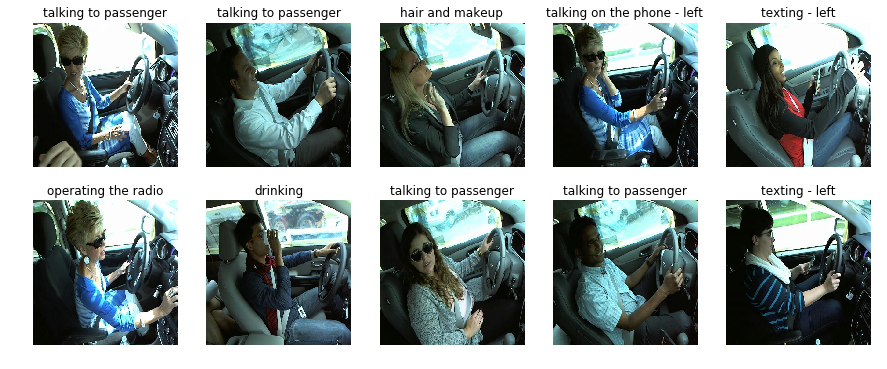

In [11]:
plot_classes(dset_loaders['train'])

# Data Analysis

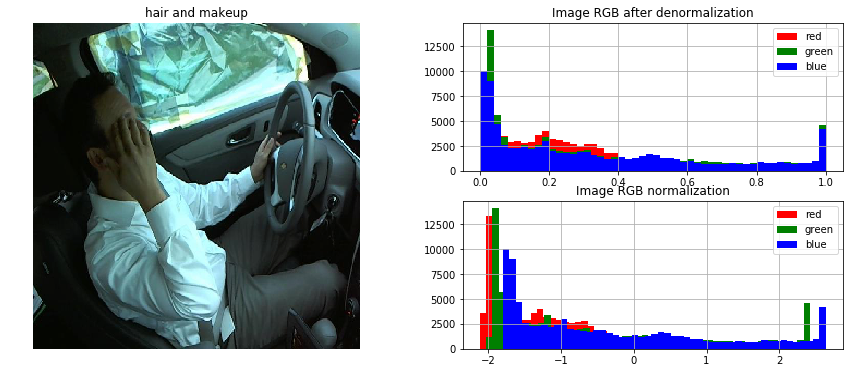

In [12]:
statistical_analysis_image(dset_loaders['train'])

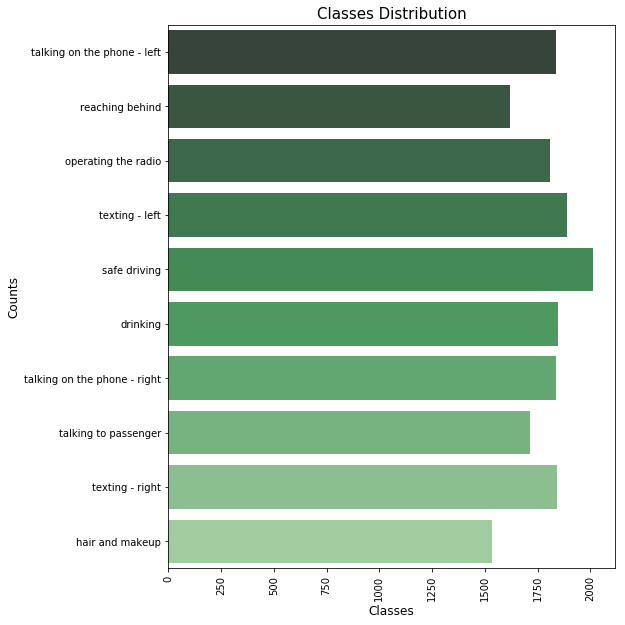

In [13]:
classDistribution(dsets['train'])

# Checking GPU usage

In [14]:
!free -h
!nvidia-smi
    

              total        used        free      shared  buff/cache   available
Mem:           220G         77G        129G        777M         12G        139G
Swap:            0B          0B          0B
Mon Nov 20 11:52:27 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   41C    P0    72W / 149W |   2805MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0

# Choosing Model

In [15]:
use_resnet = True
use_inception = False
use_denseNet = False

if use_resnet:
    print('Using ResNet model')
    model = MyResNet()
if use_inception:
    print('Using Inception model')
    model = MyInception()
if use_denseNet:
    print('Using DenseNet model')    
    model = MyDenseNet()

Using ResNet model


In [16]:
if use_gpu:
    print('Using GPU')# {}'.format(device_id))
    model.cuda()
    
if use_DataParalel:
    print("Using all GPU's ")
    model = torch.nn.DataParallel(model)
#    model.cuda()

Using GPU


In [17]:
#print(model)

In [18]:
if use_DataParalel:
    convOutput_train = ExtractFeatures(dset_loaders['train'], model.module.mrnc,use_gpu=use_DataParalel)
    convOutput_valid = ExtractFeatures(dset_loaders['valid'], model.module.mrnc,use_gpu=use_DataParalel)

if  use_gpu:    
    convOutput_train = ExtractFeatures(dset_loaders['train'], model.mrnc,use_gpu=use_gpu)
    convOutput_valid = ExtractFeatures(dset_loaders['valid'], model.mrnc,use_gpu=use_gpu)

if not use_gpu and not use_DataParalel:
    convOutput_train = ExtractFeatures(dset_loaders['train'], model.mrnc)
    convOutput_valid = ExtractFeatures(dset_loaders['valid'], model.mrnc)



predict: 99/99 ok
predict: 24/24 ok


In [19]:
print(convOutput_train['true'].size(), convOutput_train['pred'].size())
print(convOutput_valid['true'].size(), convOutput_valid['pred'].size())

torch.Size([17940]) torch.Size([17940, 6400])
torch.Size([4484]) torch.Size([4484, 6400])


In [20]:
print(convOutput_train['true'].type(), convOutput_train['pred'].type())

torch.cuda.LongTensor torch.cuda.FloatTensor


In [21]:
conv_dset ={
    'train': TensorDataset(convOutput_train['pred'], convOutput_train['true']),
    'valid': TensorDataset(convOutput_valid['pred'], convOutput_valid['true'])
} 

In [22]:
dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, 
                                  num_workers=cpu_count, use_DataParalel=True,
                                  use_gpu=False,shuffle= False)

In [23]:
len(dset_loaders_convnet['train'])

100

In [24]:
#path2saveModel = '/home/r120084/project/models/distractdriver'
path2saveModel = '/mnt/home/e209440/models/ResNetDistractDriver' 

savebest = ptt.ModelCheckpoint(path2saveModel,reset=True, verbose=1)

In [25]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 250

if use_DataParalel:
    optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
    
    params = {'model' : model.module.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }

if use_gpu:    
    
    optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
    
    params = {'model' : model.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }


    
else:    
    optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
    params = {'model' : model.mrnd, 
        'criterion': loss_fn,  
        'optimizer': optimizer, 
        'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
    }
       
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)


In [26]:
trainer = ptt.DeepNetTrainer(use_gpu=use_gpu,**params)

In [27]:
trainer.fit_loader(num_epochs, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

Start training for 250 epochs
  1:   1.7s   T: 2.44794   V: 2.20380 best
  2:   1.0s   T: 1.80110   V: 1.34529 best
  3:   1.0s   T: 0.97678   V: 0.61810 best
  4:   0.9s   T: 0.49286   V: 0.40090 best
  5:   0.9s   T: 0.24647   V: 0.21599 best
  6:   0.9s   T: 0.16740   V: 0.11943 best
  7:   0.9s   T: 0.11781   V: 0.08822 best
  8:   0.9s   T: 0.08161   V: 0.07801 best
  9:   0.9s   T: 0.07492   V: 0.12353 
 10:   0.9s   T: 0.38359   V: 0.08892 
 11:   0.9s   T: 0.07765   V: 0.08016 
 12:   0.9s   T: 0.05734   V: 0.06467 best
 13:   0.9s   T: 0.04794   V: 0.04638 best
 14:   0.9s   T: 0.05314   V: 0.04512 best
 15:   0.9s   T: 0.04006   V: 0.03497 best
 16:   0.9s   T: 0.02578   V: 0.05686 
 17:   0.9s   T: 0.29780   V: 0.13932 
 18:   0.9s   T: 0.07269   V: 0.04648 
 19:   0.9s   T: 0.02924   V: 0.05199 
 20:   0.9s   T: 0.02236   V: 0.04949 
 21:   0.9s   T: 0.01942   V: 0.04702 
 22:   0.9s   T: 0.01658   V: 0.04276 
 23:   0.9s   T: 0.01450   V: 0.03190 best
 24:   0.9s   T: 0.01

207:   0.9s   T: 0.00036   V: 0.01719 
208:   0.9s   T: 0.00034   V: 0.01717 
209:   0.9s   T: 0.00032   V: 0.01717 
210:   0.9s   T: 0.00030   V: 0.01717 
211:   0.9s   T: 0.00029   V: 0.01718 
212:   0.9s   T: 0.00027   V: 0.01718 
213:   0.9s   T: 0.00026   V: 0.01718 
214:   0.9s   T: 0.00025   V: 0.01720 
215:   0.9s   T: 0.00024   V: 0.01722 
216:   0.9s   T: 0.00022   V: 0.01724 
217:   0.9s   T: 0.00021   V: 0.01731 
218:   0.9s   T: 0.00020   V: 0.01731 
219:   0.9s   T: 0.00019   V: 0.01735 
220:   0.9s   T: 0.00018   V: 0.01735 
221:   0.9s   T: 0.00017   V: 0.01740 
222:   0.9s   T: 0.00016   V: 0.01750 
223:   0.9s   T: 0.00016   V: 0.01757 
224:   0.9s   T: 0.00015   V: 0.01765 
225:   0.9s   T: 0.00014   V: 0.01773 
226:   0.9s   T: 0.00013   V: 0.01779 
227:   0.9s   T: 0.00013   V: 0.01784 
228:   0.9s   T: 0.00012   V: 0.01782 
229:   0.9s   T: 0.00012   V: 0.01802 
230:   0.9s   T: 0.00011   V: 0.01819 
231:   0.9s   T: 0.00011   V: 0.01831 
232:   0.9s   T: 2.34098 

# Loading best epoch

In [35]:
model.mrnd = ptt.load_trainer_state(path2saveModel,model.mrnd,trainer.metrics) 

In [28]:
#model.mrnd = trainer.model  # Full trainning process

In [ ]:
if use_gpu:
    !free -h
    !nvidia-smi

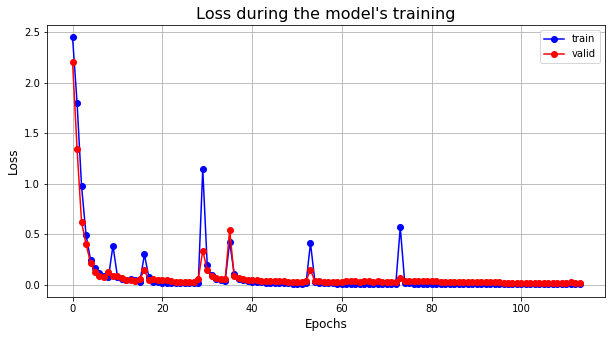

In [36]:
plot_metrics(trainer)

In [37]:
train_eval = trainer.evaluate_loader(dset_loaders_convnet['train'])
valid_eval = trainer.evaluate_loader(dset_loaders_convnet['valid'])

evaluate: 99/99 ok
evaluate: 24/24 ok


In [38]:
train_eval, valid_eval

({'losses': 0.0006969263956723984}, {'losses': 0.01641202919331797})

In [32]:
dset_loaders_wshuffle = _create_dataLoader(dsets, batch_size, num_workers=cpu_count,
                                           use_gpu=use_gpu,use_DataParalel=use_DataParalel, shuffle=False)


In [ ]:
result_train = ExtractFeatures(dset_loaders_wshuffle['train'], model,use_gpu=use_gpu)
result_valid = ExtractFeatures(dset_loaders_wshuffle['valid'], model,use_gpu=use_gpu)

In [ ]:
result_train['pred'] = getPrediction(result_train['pred'])
result_valid['pred'] = getPrediction(result_valid['pred'])

In [ ]:
result_train['pred'] = tensor2numpy(result_train['pred'])
result_train['true'] = tensor2numpy(result_train['true'])

result_valid['pred'] = tensor2numpy(result_valid['pred'])
result_valid['true'] = tensor2numpy(result_valid['true'])

In [ ]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()

In [ ]:
print('Train: ', correct_train, '/', len(conv_dset['train']) )
print('Valid: ', correct_valid, '/', len(conv_dset['valid']) )

In [ ]:
lst_correct = np.where(result_train['true'] == result_train['pred'])[0]
lst_incorrect = np.where(result_train['true'] != result_train['pred'])[0]

In [ ]:
visualize_predictions(dsets['train'],lst_correct,result_train)

In [ ]:
plot_cm_train_valid(result_train,result_valid)

In [ ]:
plot_layers_weight(dsets,img_width=224, img_height=224,conv_model = model.mrnc,use_gpu=use_gpu)